In [2]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [11]:
#Set paths 
Animal_ID = ['EJT257','EJT258','EJT259','EJT260']
#              ,'EJT212','EJT213','EJT214']
#['SP28','EJT97','EJT98','EJT99','EJT100','EJT101','EJT102','EJT103','EJT104','EJT105','EJT106','EJT107','EJT108','EJT109','EJT110','EJT111','EJT112','EJT113','EJT114','EJT115','EJT116','EJT117','EJT118','EJT119']
#['EJT64','EJT65','EJT66','EJT67','EJT68','EJT69','EJT70','EJT71','EJT72','EJT73','EJT74','EJT75','EJT76','EJT77','EJT78','EJT79','EJT80','EJT81','EJT82','EJT83','EJT84','EJT85','EJT87','EJT88','EJT89','EJT90','EJT94','EJT95','EJT96','SP19','SP20','SP21','SP22','SP27','SP28','SP29','SP30']

#'EJT63','EJT64','EJT65','EJT66','EJT67','EJT68','EJT69','EJT70','EJT71','EJT72','EJT73','EJT74','EJT75','EJT76','EJT77','EJT78','EJT79','EJT80','EJT81','EJT82','EJT83','EJT84','EJT86','EJT87','EJT89','EJT90','EJT91'
# Animal_ID = ['EJT83','EJT84','EJT85','EJT86','EJT87','EJT88','EJT89','EJT90','EJT91','EJT92','EJT93','EJT94','EJT95','EJT96','SP19','SP20','SP21','SP22','SP27','SP28','SP29','SP30']
#['EJT60','EJT61','EJT62','EJT63','EJT64','EJT65','EJT68','EJT69','EJT70','EJT71','EJT72','EJT80','EJT89','EJT90','EJT91','EJT92','EJT93','EJT94','EJT95']
#['EJT60','EJT61','EJT62','EJT63','EJT64','EJT65','EJT66','EJT67','EJT68','EJT69','EJT70','EJT71','EJT72','EJT73','EJT74','EJT75','EJT76','EJT77','EJT78','EJT79','EJT80','EJT81','EJT82','EJT83','EJT84','EJT85','EJT86','EJT87','EJT88','EJT89','EJT90','EJT91','EJT92','EJT93','EJT94','EJT95','EJT96','SP19','SP20','SP21','SP22','SP27','SP28','SP29','SP30']
#['EJT83','EJT84','EJT85','EJT86','EJT87']
#['EJT50','EJT51','EJT52','EJT53','EJT54','EJT55','EJT56','EJT57']


# to do: ['EJT45','EJT46','EJT47','EJT48','EJT49',

#,'EJT40','EJT41','EJT42','EJT46', 'EJT47', 'EJT48', 'EJT49','EJT50']

# 'EJT37', 'EJT38', 'EJT39', 'EJT40','EJT41',
InputPath = ('D:\Behavioural_data_output\\')



OutputPath = ('D:\Behavioural_data_output\\')


In [12]:
# Plot color bars for training levels (this look sgood but slows down anaysis by a lot)
HighQuality = False

In [13]:
import scipy.io
import os, importlib
import matplotlib.pyplot as plt
import statistics
import scipy.stats
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()
import tkinter as tk
from matplotlib import gridspec
import matplotlib.colors
import numpy as np
import pandas as pd
# import ptitprince as pt
from ast import literal_eval
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pickle
import shutil

plt.style.use('default')


In [14]:
def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.close()
    
def SaveFig_hold(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')

def DetermineTransitionScores(TransitionTypes_Tfilt,current_LEDi,current_Rval,Transitions,port):
    transition_scores = []
    transition_LEDi = []
    transition_Rval = []
    for index,transit in enumerate(TransitionTypes_Tfilt):
        if str(transit)[0] == str(Transitions[port-1])[0]:
            if transit == Transitions[port-1]:
                transition_scores = transition_scores + [1]
                transition_LEDi = transition_LEDi + [literal_eval(current_LEDi[index])]
                transition_Rval = transition_Rval + [literal_eval(current_Rval[index])]

            else:
                transition_scores = transition_scores+ [0]
                transition_LEDi = transition_LEDi + [literal_eval(current_LEDi[index])]
                transition_Rval = transition_Rval + [literal_eval(current_Rval[index])]
    return transition_scores, transition_LEDi, transition_Rval

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def Find_Transition_times(TransitionLatency_Tfilt,TransitionTypes_Tfilt,Transitions):
    transit_times = []
    for Transits in Transitions:
        transit_times_temp = []
        for ind, transition_pair in enumerate(TransitionTypes_Tfilt):
            if transition_pair == Transits:
                transit_times_temp = transit_times_temp + [TransitionLatency_Tfilt[ind]]
                
        transit_times = transit_times + [transit_times_temp]   
    return(transit_times)

def Moving_median(Var,window):
    cumsum, moving_meds,uqs,lqs = [0], [],[],[]
    for i, x in enumerate(Var, 1):
        if i>=window:
            moving_med = np.median(Var[i-window:i])
            lst = sorted(Var[i-window:i])
            upperquart = lst[int(0.75 * window)] 
            lowerquart = lst[int(0.25 * window)]
            #can do stuff with moving_ave here
            moving_meds.append(moving_med)
            uqs.append(upperquart)
            lqs.append(lowerquart)
    return moving_meds,uqs,lqs

def mklist(n):
    for _ in range(n):
        yield []
        
#### align to first port pokes and remove single transitions (these dont count as sequences)

def aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies):
    
    newseqs = []
    newlatencies = []
    # align to first poke:
    for index_1,fragments in enumerate(timesplitseqs):
        current_newseqs = []
        current_newlatencies = []
        count = -1
        seqs = False
        for index_2,sequence in enumerate(fragments):
            for index_3,transit in enumerate(sequence):
                if not str(transit)[0] == str(transit)[1]: # remove repeat pokes
                    if str(transit)[0] == '2':
                        seqs = True
                        current_newseqs = current_newseqs + [[]]
                        current_newlatencies = current_newlatencies + [[]]
                        count = count + 1
                        current_newseqs[count] = current_newseqs[count] + [transit]
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
                    elif seqs == True:
                        current_newseqs[count] = current_newseqs[count] + [transit]   
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
            seqs = False
 
        newseqs = newseqs + [current_newseqs]
        newlatencies = newlatencies + [current_newlatencies]
    return(newseqs,newlatencies)

def sequence_contains_sequence(haystack_seq, needle_seq):
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            return True
    return False
            
def parts(list_, indices):
    indices = [0]+indices+[len(list_)]
    return [list_[v:indices[k+1]] for k, v in enumerate(indices[:-1])]

def RemoveSlowSequences(split,split2):
    timefiltered_split = []
    for i,item in enumerate(split2):
        if item[0] == 1:
            timefiltered_split = timefiltered_split + [split[i]]

    return(timefiltered_split)

def determine_transition_score(fragments,start_port,end_port):
    correct = []
    for fragment in fragments:
        for transition in fragment:
            if str(transition)[0] == str(start_port):
                if str(transition)[1] == str(end_port):
                    correct = correct + [1]
                else:
                    correct = correct + [0]
    return(correct)

def generate_processed_transitiontimesdataframe(processed_seqs,processed_latencies,counter):

    count = counter
    transits= []
    trial_number= []
    for fragment in processed_seqs:
        count = count + 1
        if len(fragment) > 0:
            for sequence in fragment:
                for transit in sequence:
                    trial_number = trial_number + [count]
                    transits = transits + [transit]
        else: ### deals with cases where there are no good transitions in a trial 
            transits = transits + ['nan']
            trial_number = trial_number + [count]

    times = []
    for fragment in processed_latencies:
        if len(fragment) > 0:
            for sequence in fragment:
                for time in sequence:
                    times = times + [time]
        else:
            times = times + ['nan']

    Processesed_Transition_Latencies = pd.DataFrame({'Trial': trial_number, 'Transitions' : transits,'Latencies' : times})

    return(Processesed_Transition_Latencies,count)

def findTransitionTimes(Transition_id,all_sessions_latency_data):
    Transition = np.array(pd.concat(all_sessions_latency_data)['Latencies'])[np.where(np.array(pd.concat(all_sessions_latency_data)['Transitions'])==Transition_id)]
    Trials = np.array(pd.concat(all_sessions_latency_data)['Trial'])[np.where(np.array(pd.concat(all_sessions_latency_data)['Transitions'])==Transition_id)]
    return(Transition,Trials)

def find_mean_transiton_times_by_trail(transitions,trials):
    Mean_Transitions_bytrial = []
    ref_trials = []
    for i in range(len(transitions)):
        df =  pd.DataFrame({'Trials': trials[i], 'Transitions' : transitions[i]})
        split_by_trials = dict(tuple(df.groupby('Trials')))

        c_Mean_Transitions_bytrial = []
        c_ref_trials= []
        for item in split_by_trials:
            current_mean = np.mean(np.array(split_by_trials[item]['Transitions']))
            c_Mean_Transitions_bytrial = c_Mean_Transitions_bytrial + [current_mean]
            c_ref_trials = c_ref_trials + [item]

        Mean_Transitions_bytrial = Mean_Transitions_bytrial + [c_Mean_Transitions_bytrial]
        ref_trials = ref_trials + [c_ref_trials]

    return(Mean_Transitions_bytrial,ref_trials)

In [15]:
# To Do:
# the trial start and end lines seem to be mislainged in the Perfect scores across trials graph - actually i think this is fine, it just looks this was because of the convolution (movmean)...but check this. 

# change legend and trial type colors - its still set on the old style - make it so that colors represent levels or something. 

In [16]:
#### MAIN ####

for Animal_index, CurrentAnimal in enumerate(Animal_ID):
    
    print ('Processing data for: ' + CurrentAnimal)
    ## set up across Sessions data variables:
    
    #perfect plot data:
    all_sessions_perfect_scores = []
    all_sessions_t_levels = []
    all_sessions_LED_intensities = []
    all_sessions_Reward_amounts = []

    ##Transition plot data:
    transition_scores_list =[[],[],[],[]]
    transition_LEDi_list = [[],[],[],[]]
    transition_Rval_list = [[],[],[],[]]
    transitions_persession = [[],[],[],[]]
    
    ## poke numbers and latency data:
    AcrossSessionstransitions = [[],[],[],[]]
    PokesPerSession = []
    TrialsPerSession = []
    
    ##transiton scores:
    all_sessions_transition_scores = []
    all_sessions_transitionRepeat_scores = []
    
    # latency data
    all_sessions_latency_data_outin = []
    all_sessions_latency_data_inin = []
    counter = -1 # this counter keeps track of trial numbers when concatinating data later on 
    
    # stuff for lesion analysis script:
    all_sessions_transitions_pertrial = []
    all_sessions_pokes_pertrial = []
    
    # these are important for concainating trials later on!
    counter1 = -1
    counter2 = -1
    
    InputPathCurrent = (InputPath + CurrentAnimal)
    if os.path.isdir(InputPathCurrent):
        for progress, file in enumerate(os.listdir(InputPathCurrent+ '\\Preprocessed\\')):
            
  #load in data for given Animal and session:
            CurrentInputPath = (InputPathCurrent + '\\Preprocessed\\'+file+'\\')
            Session_data =  pd.read_csv((CurrentInputPath+'PreProcessed_SessionInfo.csv'))
            poke_data =  pd.read_csv((CurrentInputPath+'PreProcessed_RawPokeData.csv'))
            transition_data =  pd.read_csv((CurrentInputPath+'PreProcessed_TransitionData.csv'))
            timefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_timefilteredonly_df.csv'))
            P1alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port1aligned.csv'))
            P2alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port2aligned.csv'))
            P3alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port3aligned.csv'))
            P4alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port4aligned.csv'))
            P5alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port5aligned.csv'))
            
            RewardAmounts_df = pd.read_csv((CurrentInputPath+'PreProcessed_RewardAmounts.csv'))
            LED_Intensities_df = pd.read_csv((CurrentInputPath+'PreProcessed_LED_Intensities.csv'))
            
            port1 =  list(Session_data.loc[:,'Port1'])[0]    
            port2 =  list(Session_data.loc[:,'Port2'])[0]    
            port3 =  list(Session_data.loc[:,'Port3'])[0]  
            port4 =  list(Session_data.loc[:,'Port4'])[0]   
            port5 =  list(Session_data.loc[:,'Port5'])[0]   

            ################# perfect plot data:
        
            #split data by trials 
            trial_split_data = dict(tuple(transition_data.groupby('Trial_id')))

            # pull out transitions and timefilter data for each trial:
            transitions = []
            Tfilters= [[],[]]
            latencies = [[],[]]
            for i in trial_split_data:
                transitions = transitions + [list(trial_split_data[i].loc[:,'Transition_type'])]
                Tfilters[0] = Tfilters[0] + [list(trial_split_data[i].loc[:,'2s_Time_Filter_out_in'])]
                latencies[0] = latencies[0] +[list(trial_split_data[i].loc[:,'out_in_Latency'])]   
                # in in
                Tfilters[1] = Tfilters[1] + [list(trial_split_data[i].loc[:,'2s_Time_Filter_in_in'])]
                latencies[1] = latencies[1] +[list(trial_split_data[i].loc[:,'in_in_Latency'])]    

            # for each trial,remove transntions that were too long and split into reaminign time relevant fragments - but for both latency types, hence the loop
            timesplitseqs = [[],[]]
            for i in range(2):
                Tfilt = Tfilters[i] # use out to in pokes first then in in .
                for trial_index,time_filter in enumerate(Tfilt):
                    start_end_inds = list(np.where(np.array(time_filter)[:-1] != np.array(time_filter)[1:])[0])
                    split = parts(transitions[trial_index],list(np.array(start_end_inds)+1))
                    split2 = parts(Tfilt[trial_index],list(np.array(start_end_inds)+1))
                    TfiltSplit = RemoveSlowSequences(split,split2)
                    del split[::2] # remove every 2nd item eg. all the transitions that were timefilter = 0 so were too long. 
                    timesplitseqs[i] = timesplitseqs[i] + [TfiltSplit]
                
            ## do the exact same for latency - but for both latency types, hence the loop:
            timesplitlatencies = [[],[]]
            for i in range(2):
                Tfilt = Tfilters[i] 
                latency = latencies[i]
                for trial_index,time_filter in enumerate(Tfilt):
                    start_end_inds = list(np.where(np.array(time_filter)[:-1] != np.array(time_filter)[1:])[0])
                    split = parts(latency[trial_index],list(np.array(start_end_inds)+1))
                    split2 = parts(Tfilt[trial_index],list(np.array(start_end_inds)+1))
                    TfiltSplit = RemoveSlowSequences(split,split2)
                    del split[::2] # remove every 2nd item eg. all the latencies that were timefilter = 0 so were too long. 
                    timesplitlatencies[i] = timesplitlatencies[i] + [TfiltSplit]
                

            # for fragments in each trial,sort and trim so that seqs start at initiation port poke and then remove fragments that are too short. ie. remove any transitions sequences that dont inlcude the first port or are just a single transition.
            processed_seqs,processed_latencies = aligntofirstpokeandremovesingletransits(timesplitseqs[0],timesplitlatencies[0])  ## use  timesplitlatencies[0] for Out to in Transition times 
            
            ## generate processed transition times dataframe:
            Processesed_Transition_Latencies_df,counter1 = generate_processed_transitiontimesdataframe(processed_seqs,processed_latencies,counter1)
            
            ## determine perfect sequences and correspondng training level and shaping parameters
            trial_perfects = []
            T_CorrectScores = [[],[],[],[]]
            T_RepeatScores = [[],[],[],[]]

            for trial_index,fragments in enumerate(processed_seqs):
                perfect = []
                for fragment in fragments:
                    if sequence_contains_sequence(fragment,[21, 16, 63, 37]):
                        perfect = perfect + [1]
                    else:
                        perfect = perfect + [0]

                trial_perfects = trial_perfects + [perfect]    
                
                
                # transition scores:
                ports = [port1,port2,port3,port4,port5]
                for i in range(0,4):
                    T_CorrectScores[i] = T_CorrectScores[i] + [determine_transition_score(fragments,ports[i],ports[i+1])]
                    
                    
            # for lesion analsis script:
            transit_trials = np.array(transition_data['Trial_id'])
            out_in_transit_latencies = np.array(transition_data['out_in_Latency'])
#             in_in_transit_latencies = np.array(transition_data['in_in_Latency'])
            transitions_pertrial = transit_trials[np.where(out_in_transit_latencies<2)]
            pokes_pertrial = np.array(poke_data['Trial_id'])

            npokes_pertrial = []
            for i in range(1,pokes_pertrial[-1]+1):
                npokes_pertrial = npokes_pertrial + [len(np.where(pokes_pertrial == i)[0])]

            ntransitions_pertrial = []
            for i in range(1,transitions_pertrial[-1]+1):
                ntransitions_pertrial = ntransitions_pertrial + [len(np.where(transitions_pertrial == i)[0])]

            all_sessions_transitions_pertrial = all_sessions_transitions_pertrial +ntransitions_pertrial
            all_sessions_pokes_pertrial = all_sessions_pokes_pertrial + npokes_pertrial
            ## across sessions:
                            
            with open (CurrentInputPath+'Preprocessed_TrainingLevels' , 'rb') as fp:
                TrainingLevels = list(pickle.load(fp))
                
            Reward_amounts = [list(RewardAmounts_df['Port1']),list(RewardAmounts_df['Port2']),list(RewardAmounts_df['Port3']),list(RewardAmounts_df['Port4'])]
            LED_intensities = [list(LED_Intensities_df['Port2']),list(LED_Intensities_df['Port3']),list(LED_Intensities_df['Port4']),list(LED_Intensities_df['Port5'])]

            all_sessions_perfect_scores = all_sessions_perfect_scores + [trial_perfects]
            all_sessions_t_levels = all_sessions_t_levels + [TrainingLevels]
            all_sessions_LED_intensities = all_sessions_LED_intensities + [LED_intensities]
            all_sessions_Reward_amounts = all_sessions_Reward_amounts + [Reward_amounts]  
            all_sessions_transition_scores = all_sessions_transition_scores + [T_CorrectScores]
            all_sessions_transitionRepeat_scores = all_sessions_transitionRepeat_scores + [T_RepeatScores]  
            all_sessions_latency_data_outin = all_sessions_latency_data_outin + [Processesed_Transition_Latencies_df]
            
            ### ININ - process data again but with in to in trasnit times to get the latencies dataframe for this type:
            processed_seqs_inin,processed_latencies_inin = aligntofirstpokeandremovesingletransits(timesplitseqs[1],timesplitlatencies[1]) # the [1] indicates that these are the variables calculated from in in transition times  
            Processesed_Transition_Latencies_df_inin,counter2 = generate_processed_transitiontimesdataframe(processed_seqs_inin,processed_latencies_inin,counter2)
            all_sessions_latency_data_inin = all_sessions_latency_data_inin + [Processesed_Transition_Latencies_df_inin]
            
            #print progress update
            print('Finished: ' + str(progress+1) + '/' + str(len(os.listdir(InputPathCurrent+ '\\Preprocessed\\'))))
                
    print('Plotting...')

    ## remove old version of output dir 
    if os.path.isdir(InputPathCurrent + '\\AcrossSessions\\'):
        shutil.rmtree(InputPathCurrent + '\\AcrossSessions\\',ignore_errors=True)

#######################################################################################################################################################################################################################################################################################################################################
    ## perfect sequences plot:
    # for each trial, sequences of pokes that are temporaly relevant are extracted and split into seprate sequences, these sequences are then ignored ifg they dont contain an initiation poke, if they do, everyhing before this is ignored. 
    # You are then left with a few sequence fragments that start with an initiation poke. some trials will have several some trials will have 1 of these frgaments. look for perfect sequences in these fragments and find mean or each trial (1 perfect seqience = score of 1, 1 perfect , 1 wrong = score of 0.5 etc.)
    # no fragments or no  perfect seq = score of 0. Then convolve across these P scores to plot:
#######################################################################################################################################################################################################################################################################################################################################

    # reconfigure data for plotting:

    trials_per_session= []
    for i in range(len(all_sessions_t_levels)):
        trials_per_session = trials_per_session + [len(all_sessions_t_levels[i])]
    cum_trials_per_session = np.cumsum(trials_per_session)

    TrainLevelsAll = sum(all_sessions_t_levels, [])

    LED_intensitiesAll = [[],[],[],[]]
    for ind in range(0,4):
        for i in range(len(all_sessions_LED_intensities)):
            LED_intensitiesAll[ind] = LED_intensitiesAll[ind] + all_sessions_LED_intensities[i][ind]
                                                                
    RewardValsAll = [[],[],[],[]]
    for ind in range(0,4):
        for i in range(len(all_sessions_Reward_amounts)):
            RewardValsAll[ind] = RewardValsAll[ind] + all_sessions_Reward_amounts[i][ind]

    perfectscore_trials = []
    for i in range(len(all_sessions_perfect_scores)):
        for trial in all_sessions_perfect_scores[i]:
            if len(trial) == 0:
                perfectscore_trials = perfectscore_trials + [0]
            else:
                perfectscore_trials = perfectscore_trials + [np.mean(trial)]

    # plot:
    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot2grid((5, 3), (1, 0), rowspan =5,colspan =3)   
    
    ax.set_ylim([0, 1])

    ax.plot(convolve_movmean(perfectscore_trials,75),color = 'black',linewidth = 1.5,zorder=11)


    ax.set_title('Perfect Scores', loc = 'left', size = 10, color = 'black')
    ax.set_xlabel('Trials', fontsize = 15)
    ax.set_ylabel('P Score',fontsize = 15, color = 'black')

    ax_2=ax.twinx()
    ax_2.plot(TrainLevelsAll,linewidth = 1,color = 'firebrick')
    ax_2.set_ylabel('Training Level',fontsize = 15, color = 'firebrick')
    
    for n_trials in cum_trials_per_session:
        ax.vlines(n_trials, 0, 1, color = 'grey',alpha = 0.3,zorder=10) 


     ## plot color gradients for reward and light guidance:

    if HighQuality == True:
        ax2 =  plt.subplot2grid((5, 3), (0, 0), rowspan =1,colspan =3)
        c1 = 'orange'
        c2 = 'navy'
        c3 = 'white'
        
        for i in range(0,4):
            for ind, value in enumerate(LED_intensitiesAll[i]):
                if ind == 0:
                    prev = 0
                else:
                    prev = ind-1

                normalised_value = value/90
                if not normalised_value == 0:
                    ax2.hlines(i+4, prev, ind, color=colorFader(c3,c1,normalised_value), linewidth=4)

                # plot an invisible point at the end to keep axis scaling the same
                if ind == len(LED_intensitiesAll[i]) - 1:
                    ax2.plot(ind,0,'.',color = 'white')

                normalised_Rvalue = RewardValsAll[i][ind]/5 # 5 = max r val
                if not normalised_Rvalue == 0:
                    ax2.hlines(i, prev, ind, color=colorFader(c3,c2,normalised_Rvalue), linewidth=4)

        ax2.set_frame_on(False)  

        labels=['Port 1 water','Port 2 water','Port 3 water','Port 4 water','Port 2 LED','Port 3 LED','Port 4 LED','Port 5 LED']
        ax2.set_yticks((0,1,2,3,4,5,6,7))
        ax2.set_yticklabels(labels)

        ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

    plt.tight_layout()   

    SaveFig_hold('PerfectScores ' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[0] + 'to' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[-1] + '.png',InputPathCurrent + '\\AcrossSessions\\')

    if 50 in TrainLevelsAll:
        full_task = True
        to_full_task = np.where(np.array(TrainLevelsAll) == 50)[0][0]
    else:
        full_task = False
        
        
    if full_task == True:
        if len(TrainLevelsAll)-to_full_task>1000:
            ax.set_xlim([0, to_full_task+1000])
            if HighQuality == True:
                ax2.set_xlim([0, to_full_task+1000])
            ax.set_title('Perfect Scores to level 50 + 1000 trials', size = 10, color = 'black')
            SaveFig('PerfectScoresToFinalTask_+1000trials.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')
        else: 
            ax.set_xlim([0, to_full_task])
            ax.set_title('Perfect Scores to level 50', size = 10, color = 'black')
            ax2.set_xlim([0, to_full_task])
            SaveFig('PerfectScoresToFinalTask.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')

    
    #Save out Perfect scores data:
    filepath = OutputPath + Animal_ID[Animal_index] + ('\\AcrossSessions\\AnalysisOutput\\')
    if not os.path.isdir(filepath):
        os.makedirs(filepath)

    filename = 'PerfectScore_trials'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(perfectscore_trials, fp)

    if full_task == True:
        filename = 'Trials_to_Full_Task'
        with open(filepath + filename, 'wb') as fp:
            pickle.dump(to_full_task, fp)

        

#######################################################################################################################################################################################################################################################################################################################################            
##### Transition scores: 
#use same data as perfect scores but look for each transition, ignoring any transitions from irrelevant ports
#######################################################################################################################################################################################################################################################################################################################################            

    Transitionscore_trials = [[],[],[],[]]
    for x in range(len(Transitionscore_trials)):
        for i in range(len(all_sessions_transition_scores)):
            for trial in all_sessions_transition_scores[i][x]:
                if len(trial) == 0:
                    Transitionscore_trials[x] = Transitionscore_trials[x] + [0]
                else:
                    Transitionscore_trials[x] = Transitionscore_trials[x] + [np.mean(trial)]


    # # plot:

    fig = plt.figure(figsize=(20, 10))

    ax = plt.subplot2grid((5, 3), (1, 0), rowspan =5,colspan =3)   

    colors = ['Maroon','tab:red','tab:orange','tab:purple']
    # for ind, ax in enumerate(fig.axes):
    for ind in range(0,4):
        ax.set_ylim([0, 1])
        ax.plot(convolve_movmean(Transitionscore_trials[ind],75),color = colors[ind],linewidth = 1.5,zorder=11)

        ax.set_title('Subsequence transition scores', loc = 'left', size = 10, color = 'black')
        ax.set_xlabel('Trials', fontsize = 15)
        ax.set_ylabel('T Score',fontsize = 15, color = 'tab:red')

        ax2=ax.twinx()
        ax2.plot(TrainLevelsAll,linewidth = 1,color = 'k')
        ax2.set_ylabel('Training Level',fontsize = 15, color = 'k')

    Legend = []
    for i in range(0,4):
        Legend = Legend + [mpatches.Patch(color=colors[i], label=('Transition' + str(i+1)))]
    ax.legend(handles = Legend,frameon=False,fontsize = 12, loc = 'right')

    for n_trials in cum_trials_per_session:
        ax.vlines(n_trials, 0, 1, color = 'grey',alpha = 0.3,zorder=10) 


     ## plot color gradients for reward and light guidance:
    if HighQuality == True:
        ax2 =  plt.subplot2grid((5, 3), (0, 0), rowspan =1,colspan =3)
        for i in range(0,4):
            for ind, value in enumerate(LED_intensitiesAll[i]):
                if ind == 0:
                    prev = 0
                else:
                    prev = ind-1

                normalised_value = value/90
                if not normalised_value == 0:
                    ax2.hlines(i+4, prev, ind, color=colorFader(c3,c1,normalised_value), linewidth=4)

                # plot an invisible point at the end to keep axis scaling the same
                if ind == len(LED_intensitiesAll[i]) - 1:
                    ax2.plot(ind,0,'.',color = 'white')

                normalised_Rvalue = RewardValsAll[i][ind]/5 # 5 = max r val
                if not normalised_Rvalue == 0:
                    ax2.hlines(i, prev, ind, color=colorFader(c3,c2,normalised_Rvalue), linewidth=4)

        ax2.set_frame_on(False)  

        labels=['Port 1 water','Port 2 water','Port 3 water','Port 4 water','Port 2 LED','Port 3 LED','Port 4 LED','Port 5 LED']
        ax2.set_yticks((0,1,2,3,4,5,6,7))
        ax2.set_yticklabels(labels)

        ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

    plt.tight_layout()   


    SaveFig_hold('TransitionScores ' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[0] + 'to' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[-1] + '.png',InputPathCurrent + '\\AcrossSessions\\')

    if full_task == True:
        if len(TrainLevelsAll)-to_full_task>1000:
            ax.set_xlim([0, to_full_task+1000])
            ax.set_title('Transition Scores to level 50 + 1000 trials', size = 10, color = 'black')
            if HighQuality == True: 
                ax2.set_xlim([0, to_full_task+1000])
            SaveFig('TransitionScoresToFinalTask_+1000trials.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')
        else: 
            ax.set_xlim([0, to_full_task])
            ax.set_title('Transition Scores to level 50', size = 10, color = 'black')
            ax2.set_xlim([0, to_full_task])
            SaveFig('TransitionScoresToFinalTask.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')


    #Save out transition scores data:
    filename = 'TransitionScore_trials'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(Transitionscore_trials, fp)
        
        
    #######################################################################################################################################################################################################################################################################################################################################            

        ##### Trials per session

    #######################################################################################################################################################################################################################################################################################################################################            



    fig,[ax,ax2] = plt.subplots(1, 2, figsize=(35, 10))
    ax.plot(cum_trials_per_session,'o-',color = 'firebrick')
    ax2.plot(trials_per_session,'o-', color = 'c')

    ax.set_xlabel('Sessions',fontsize = 15, color = 'k')
    ax2.set_xlabel('Sessions',fontsize = 15, color = 'k')
    ax.set_ylabel('Trials',fontsize = 15, color = 'k')
    ax2.set_ylabel('Trials',fontsize = 15, color = 'k')
    ax.set_title('Cumulative trials completed', size = 10, color = 'black',loc = 'left')
    ax2.set_title('Trials completed by session', size = 10, color = 'black',loc = 'left')
    ax.tick_params(axis="y", labelsize=9)
    ax.tick_params(axis="x", labelsize=9)

    SaveFig('TrialsPerSessions.png',InputPathCurrent + '\\AcrossSessions\\')

    ## save out this data:

    #Save out transition scores data:
    filename = 'TrialsPerSessions'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(trials_per_session, fp)
   

    #######################################################################################################################################################################################################################################################################################################################################            

        ##### Transitions times per trial

    #######################################################################################################################################################################################################################################################################################################################################            



    ## pull out transition times and trial reference for each subseq movement:
    seq = [21,16,63,37]
    transitions = [[]]
    trials = [[]]

    for i in range (len(seq)):
        transitions[i],trials[i] = findTransitionTimes(seq[i],all_sessions_latency_data_outin)
        transitions = transitions + [[]]
        trials = trials + [[]]

    ## find the average time taken for each transition per trial (this should be just calculated across just 1 number unless the mouse did multiple transitions in 1 trial (eg. error trials))
    Mean_Transitions_bytrial, ref_trials = find_mean_transiton_times_by_trail(transitions,trials)
    
    ## Plot:

    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot2grid((5, 3), (1, 0), rowspan =5,colspan =3)

    for ind in range(4):
        ax.plot(ref_trials[ind],convolve_movmean(Mean_Transitions_bytrial[ind],100), color = colors[ind])

    ax.set_title('Transition times [Port OUT to Port IN]', loc = 'left', size = 10, color = 'black')
    ax.set_xlabel('Trials', fontsize = 15)
    ax.set_ylabel('Transition time',fontsize = 15, color = 'firebrick')

    ax_2=ax.twinx()
    ax_2.plot(TrainLevelsAll,linewidth = 1,color = 'black')
    ax_2.set_ylabel('Training Level',fontsize = 15, color = 'black')


    Legend = []
    for i in range(0,4):
        Legend = Legend + [mpatches.Patch(color=colors[i], label=('Transition' + str(i+1)))]
    ax.legend(handles = Legend,frameon=False,fontsize = 12, loc = 'right')


    ## plot color gradients for reward and light guidance:
    if HighQuality == True:
        ax2 =  plt.subplot2grid((5, 3), (0, 0), rowspan =1,colspan =3)

        for i in range(0,4):
            for ind, value in enumerate(LED_intensitiesAll[i]):
                if ind == 0:
                    prev = 0
                else:
                    prev = ind-1

                normalised_value = value/90
                if not normalised_value == 0:
                    ax2.hlines(i+4, prev, ind, color=colorFader(c3,c1,normalised_value), linewidth=4)

                # plot an invisible point at the end to keep axis scaling the same
                if ind == len(LED_intensitiesAll[i]) - 1:
                    ax2.plot(ind,0,'.',color = 'white')

                normalised_Rvalue = RewardValsAll[i][ind]/5 # 5 = max r val
                if not normalised_Rvalue == 0:
                    ax2.hlines(i, prev, ind, color=colorFader(c3,c2,normalised_Rvalue), linewidth=4)

        ax2.set_frame_on(False)  


        labels=['Port 1 water','Port 2 water','Port 3 water','Port 4 water','Port 2 LED','Port 3 LED','Port 4 LED','Port 5 LED']
        ax2.set_yticks((0,1,2,3,4,5,6,7))
        ax2.set_yticklabels(labels)

        ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

    plt.tight_layout()

    SaveFig_hold('Transition_times_OutIn_tofinaltask+1000_trials' + '.png',InputPathCurrent + '\\AcrossSessions\\')

    if full_task == True:
        if len(TrainLevelsAll)-to_full_task>1000:
            ax.set_xlim([0, to_full_task+1000])
            if HighQuality == True:    
                ax2.set_xlim([0, to_full_task+1000])
            ax.set_title('Transition times to level 50 + 1000 trials', size = 10, color = 'black')
            SaveFig('TransitionTimes_OutIn_ToFinalTask_+1000trials.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')
        else: 
            ax.set_xlim([0, to_full_task])
            ax2.set_xlim([0, to_full_task])
            ax.set_title('Transition times to level 50', size = 10, color = 'black')
            SaveFig('TransitionTimes_OutIn_ToFinalTask.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')

            
        #Save out transition times data for OUt to in:
    filename = 'MeanTransitionTimes_bytrial_outin'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(Mean_Transitions_bytrial, fp)
        
        # tranitions times are only calculated for trials where mouse did a viable transition so to use this data you nee dot know which trials these corespond to: 
    filename = 'MeanTransitionTimes_bytrial_outin_REFERENCES'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(ref_trials, fp)
        
 #######################################################################################################################################################################################################################################################################################################################################            

        ##### Transitions times per trial
    #### same agin but but port in to port in:
#######################################################################################################################################################################################################################################################################################################################################            

    transitions = [[]]
    trials = [[]]
    for i in range (len(seq)):
        transitions[i],trials[i] = findTransitionTimes(seq[i],all_sessions_latency_data_inin)
        transitions = transitions + [[]]
        trials = trials + [[]]

    ## find the average time taken for each transition per trial (this should be just calculated across just 1 number unless the mouse did multiple transitions in 1 trial (eg. error trials))
    Mean_Transitions_bytrial, ref_trials = find_mean_transiton_times_by_trail(transitions,trials)

    ## Plot:

    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot2grid((5, 3), (1, 0), rowspan =5,colspan =3)

    for ind in range(4):
        ax.plot(ref_trials[ind],convolve_movmean(Mean_Transitions_bytrial[ind],100), color = colors[ind])

    ax.set_title('Transition times [Port IN to Port IN]', loc = 'left', size = 10, color = 'black')
    ax.set_xlabel('Trials', fontsize = 15)
    ax.set_ylabel('Transition time',fontsize = 15, color = 'firebrick')

    ax_2=ax.twinx()
    ax_2.plot(TrainLevelsAll,linewidth = 1,color = 'black')
    ax_2.set_ylabel('Training Level',fontsize = 15, color = 'black')


    Legend = []
    for i in range(0,4):
        Legend = Legend + [mpatches.Patch(color=colors[i], label=('Transition' + str(i+1)))]
    ax.legend(handles = Legend,frameon=False,fontsize = 12, loc = 'right')


    ## plot color gradients for reward and light guidance:
    if HighQuality == True:
        ax2 =  plt.subplot2grid((5, 3), (0, 0), rowspan =1,colspan =3)

        for i in range(0,4):
            for ind, value in enumerate(LED_intensitiesAll[i]):
                if ind == 0:
                    prev = 0
                else:
                    prev = ind-1

                normalised_value = value/90
                if not normalised_value == 0:
                    ax2.hlines(i+4, prev, ind, color=colorFader(c3,c1,normalised_value), linewidth=4)

                # plot an invisible point at the end to keep axis scaling the same
                if ind == len(LED_intensitiesAll[i]) - 1:
                    ax2.plot(ind,0,'.',color = 'white')

                normalised_Rvalue = RewardValsAll[i][ind]/5 # 5 = max r val
                if not normalised_Rvalue == 0:
                    ax2.hlines(i, prev, ind, color=colorFader(c3,c2,normalised_Rvalue), linewidth=4)

        ax2.set_frame_on(False)  


        labels=['Port 1 water','Port 2 water','Port 3 water','Port 4 water','Port 2 LED','Port 3 LED','Port 4 LED','Port 5 LED']
        ax2.set_yticks((0,1,2,3,4,5,6,7))
        ax2.set_yticklabels(labels)

        ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

    plt.tight_layout()

    SaveFig_hold('Transition_times_InIn_tofinaltask+1000_trials' + '.png',InputPathCurrent + '\\AcrossSessions\\')

    if full_task == True:
        if len(TrainLevelsAll)-to_full_task>1000:
            ax.set_xlim([0, to_full_task+1000])
            if HighQuality == True:
                ax2.set_xlim([0, to_full_task+1000])
            ax.set_title('Transition times to level 50 + 1000 trials', size = 10, color = 'black')
            SaveFig('TransitionTimes_InIn_ToFinalTask_+1000trials.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')
        else: 
            ax.set_xlim([0, to_full_task])
            ax2.set_xlim([0, to_full_task])
            ax.set_title('Transition times to level 50', size = 10, color = 'black')
            SaveFig('TransitionTimes_InIn_ToFinalTask.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')


#######################################################################################################################################################################################################################################################################################################################################            
#Save out all unsaved data:
#######################################################################################################################################################################################################################################################################################################################################            

    #Save out transition times data:
    filename = 'MeanTransitionTimes_bytrial_inin'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(Mean_Transitions_bytrial, fp)
        
    # tranitions times are only calculated for trials where mouse did a viable transition so to use this data you nee dot know which trials these corespond to: 
    filename = 'MeanTransitionTimes_bytrial_inin_REFERENCES'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(ref_trials, fp)
        
    #save out training level data:
    filename = 'Training_levels'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(TrainLevelsAll, fp)
        

    #save out data for lesion scripts:
    filename = 'Transitions_PerTrial'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(all_sessions_transitions_pertrial, fp)
    
    #save out data for lesion scripts:
    filename = 'pokes_PerTrial'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(all_sessions_pokes_pertrial, fp)
        
        

Processing data for: EJT257
Finished: 1/47
Finished: 2/47
Finished: 3/47
Finished: 4/47
Finished: 5/47
Finished: 6/47
Finished: 7/47
Finished: 8/47
Finished: 9/47
Finished: 10/47
Finished: 11/47
Finished: 12/47
Finished: 13/47
Finished: 14/47
Finished: 15/47
Finished: 16/47
Finished: 17/47
Finished: 18/47
Finished: 19/47
Finished: 20/47
Finished: 21/47
Finished: 22/47
Finished: 23/47
Finished: 24/47
Finished: 25/47
Finished: 26/47
Finished: 27/47
Finished: 28/47
Finished: 29/47
Finished: 30/47
Finished: 31/47
Finished: 32/47
Finished: 33/47
Finished: 34/47
Finished: 35/47
Finished: 36/47
Finished: 37/47
Finished: 38/47
Finished: 39/47
Finished: 40/47
Finished: 41/47
Finished: 42/47
Finished: 43/47
Finished: 44/47
Finished: 45/47
Finished: 46/47
Finished: 47/47
Plotting...
Processing data for: EJT258
Finished: 1/54
Finished: 2/54
Finished: 3/54
Finished: 4/54
Finished: 5/54
Finished: 6/54
Finished: 7/54
Finished: 8/54
Finished: 9/54
Finished: 10/54
Finished: 11/54
Finished: 12/54
Finish

In [17]:
perfectscore_trials

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.5,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.5,
 0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0

In [23]:
#######################################################################################################################################################################################################################################################################################################################################
    ## perfect sequences plot:
    # for each trial, sequences of pokes that are temporaly relevant are extracted and split into seprate sequences, these sequences are then ignored ifg they dont contain an initiation poke, if they do, everyhing before this is ignored. 
    # You are then left with a few sequence fragments that start with an initiation poke. some trials will have several some trials will have 1 of these frgaments. look for perfect sequences in these fragments and find mean or each trial (1 perfect seqience = score of 1, 1 perfect , 1 wrong = score of 0.5 etc.)
    # no fragments or no  perfect seq = score of 0. Then convolve across these P scores to plot:
#######################################################################################################################################################################################################################################################################################################################################

# reconfigure data for plotting:

trials_per_session= []
for i in range(len(all_sessions_t_levels)):
    trials_per_session = trials_per_session + [len(all_sessions_t_levels[i])]
cum_trials_per_session = np.cumsum(trials_per_session)

TrainLevelsAll = sum(all_sessions_t_levels, [])

LED_intensitiesAll = [[],[],[],[]]
for ind in range(0,4):
    for i in range(len(all_sessions_LED_intensities)):
        LED_intensitiesAll[ind] = LED_intensitiesAll[ind] + all_sessions_LED_intensities[i][ind]

RewardValsAll = [[],[],[],[]]
for ind in range(0,4):
    for i in range(len(all_sessions_Reward_amounts)):
        RewardValsAll[ind] = RewardValsAll[ind] + all_sessions_Reward_amounts[i][ind]

perfectscore_trials = []
for i in range(len(all_sessions_perfect_scores)):
    for trial in all_sessions_perfect_scores[i]:
        if len(trial) == 0:
            perfectscore_trials = perfectscore_trials + [0]
        else:
            perfectscore_trials = perfectscore_trials + [np.mean(trial)]

# plot:
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot2grid((5, 3), (1, 0), rowspan =5,colspan =3)   

ax.set_xlim([0, 2500])

# ax.plot(convolve_movmean(perfectscore_trials,75),color = 'black',linewidth = 1.5,zorder=11)


# ax.set_title('Perfect Scores', loc = 'left', size = 10, color = 'black')
ax.set_xlabel('Trials', fontsize = 15)
ax.set_ylabel('Training Level',fontsize = 15, color = 'black')

# ax_2=ax.twinx()
ax.plot(TrainLevelsAll,linewidth = 1,color = 'firebrick')
# ax_2.set_ylabel('Training Level',fontsize = 15, color = 'firebrick')

# for n_trials in cum_trials_per_session:
#     ax.vlines(n_trials, 0, 1, color = 'grey',alpha = 0.3,zorder=10) 


 ## plot color gradients for reward and light guidance:

if HighQuality == True:
    ax2 =  plt.subplot2grid((5, 3), (0, 0), rowspan =1,colspan =3)
    c1 = 'orange'
    c2 = 'navy'
    c3 = 'white'

    for i in range(0,4):
        for ind, value in enumerate(LED_intensitiesAll[i]):
            if ind == 0:
                prev = 0
            else:
                prev = ind-1

            normalised_value = value/90
            if not normalised_value == 0:
                ax2.hlines(i+4, prev, ind, color=colorFader(c3,c1,normalised_value), linewidth=4)

            # plot an invisible point at the end to keep axis scaling the same
            if ind == len(LED_intensitiesAll[i]) - 1:
                ax2.plot(ind,0,'.',color = 'white')

            normalised_Rvalue = RewardValsAll[i][ind]/5 # 5 = max r val
            if not normalised_Rvalue == 0:
                ax2.hlines(i, prev, ind, color=colorFader(c3,c2,normalised_Rvalue), linewidth=4)

    ax2.set_frame_on(False)  

    labels=['Port 1 water','Port 2 water','Port 3 water','Port 4 water','Port 2 LED','Port 3 LED','Port 4 LED','Port 5 LED']
    ax2.set_yticks((0,1,2,3,4,5,6,7))
    ax2.set_yticklabels(labels)

    ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

plt.tight_layout()   

SaveFig_hold('PerfectScores ' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[0] + 'to' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[-1] + '.png',InputPathCurrent + '\\AcrossSessions\\')

if 50 in TrainLevelsAll:
    full_task = True
    to_full_task = np.where(np.array(TrainLevelsAll) == 50)[0][0]
else:
    full_task = False
        
        
#     if full_task == True:
#         if len(TrainLevelsAll)-to_full_task>1000:
#             ax.set_xlim([0, to_full_task+1000])
#             if HighQuality == True:
#                 ax2.set_xlim([0, to_full_task+1000])
#             ax.set_title('Perfect Scores to level 50 + 1000 trials', size = 10, color = 'black')
#             SaveFig('PerfectScoresToFinalTask_+1000trials.png',InputPathCurrent + '\AcrossSessions\\ToFinalTask\\')
#         else: 
#             ax.set_xlim([0, to_full_task])
#             ax.set_title('Perfect Scores to level 50', size = 10, color = 'black')
#             ax2.set_xlim([0, to_full_task])
SaveFig('PerfectScoresToFinalTask.svg','D:\\')

    
#     #Save out Perfect scores data:
#     filepath = OutputPath + Animal_ID[Animal_index] + ('\\AcrossSessions\\AnalysisOutput\\')
#     if not os.path.isdir(filepath):
#         os.makedirs(filepath)

#     filename = 'PerfectScore_trials'
#     with open(filepath + filename, 'wb') as fp:
#         pickle.dump(perfectscore_trials, fp)

#     if full_task == True:
#         filename = 'Trials_to_Full_Task'
#         with open(filepath + filename, 'wb') as fp:
#             pickle.dump(to_full_task, fp)

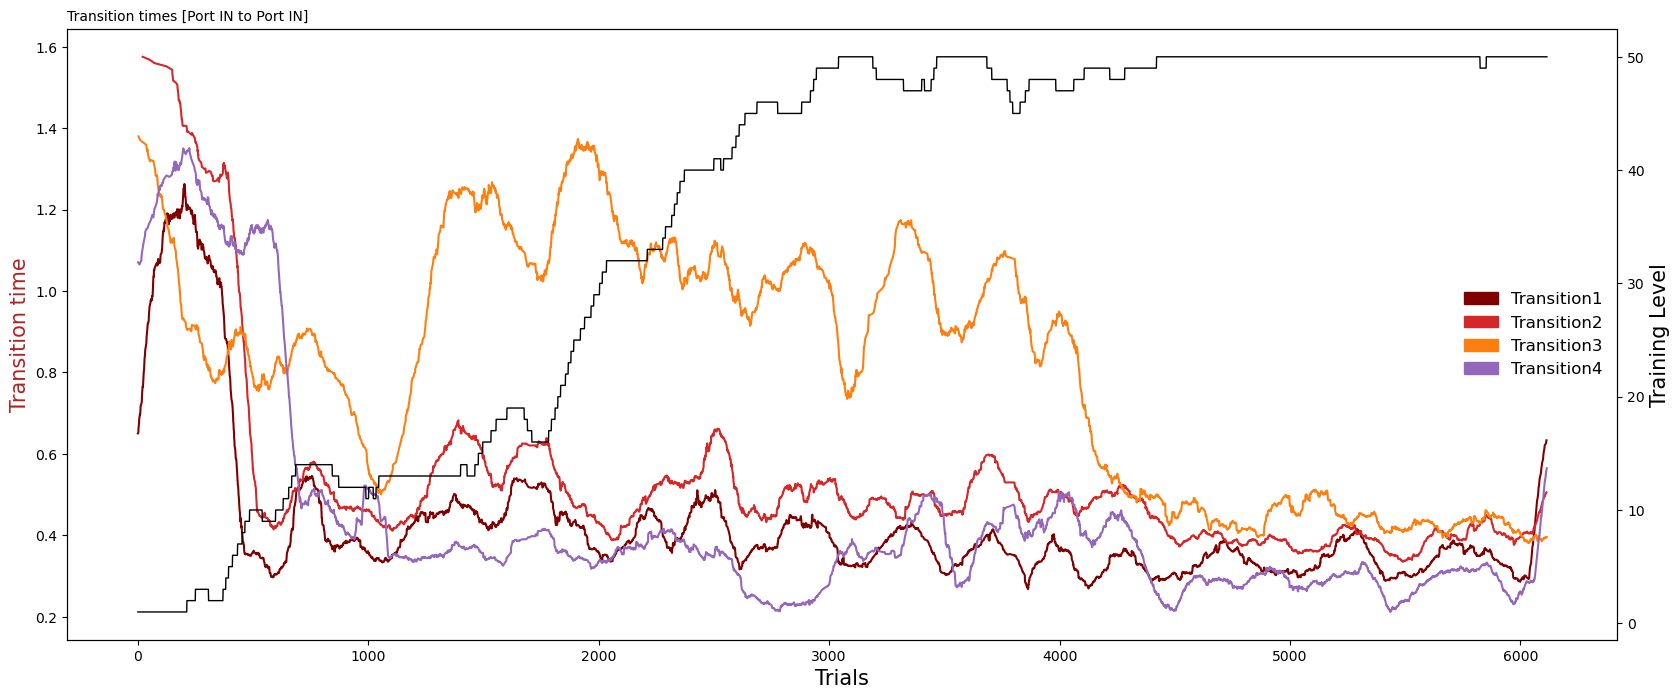

In [306]:
transitions = [[]]
trials = [[]]
for i in range (len(seq)):
    transitions[i],trials[i] = findTransitionTimes(seq[i],all_sessions_latency_data_inin)
    transitions = transitions + [[]]
    trials = trials + [[]]

## find the average time taken for each transition per trial (this should be just calculated across just 1 number unless the mouse did multiple transitions in 1 trial (eg. error trials))
Mean_Transitions_bytrial, ref_trials = find_mean_transiton_times_by_trail(transitions,trials)

## Plot:

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot2grid((5, 3), (1, 0), rowspan =5,colspan =3)

for ind in range(4):
    ax.plot(ref_trials[ind],convolve_movmean(Mean_Transitions_bytrial[ind],100), color = colors[ind])

ax.set_title('Transition times [Port IN to Port IN]', loc = 'left', size = 10, color = 'black')
ax.set_xlabel('Trials', fontsize = 15)
ax.set_ylabel('Transition time',fontsize = 15, color = 'firebrick')

ax_2=ax.twinx()
ax_2.plot(TrainLevelsAll,linewidth = 1,color = 'black')
ax_2.set_ylabel('Training Level',fontsize = 15, color = 'black')


Legend = []
for i in range(0,4):
    Legend = Legend + [mpatches.Patch(color=colors[i], label=('Transition' + str(i+1)))]
ax.legend(handles = Legend,frameon=False,fontsize = 12, loc = 'right')



In [ ]:
Mean_Transitions_bytrial[ind]

In [288]:
trials

[array([  0,   2,   3, ..., 191, 197, 199], dtype=int64),
 array([ 21,  51,   0, ..., 195, 197, 199], dtype=int64),
 array([  3,   8,  16, ..., 199, 200, 200], dtype=int64),
 array([  1,   7,  15, ..., 199, 200, 200], dtype=int64),
 []]

In [ ]:
## To do:

#time for each transniton across transitions

# av time for full sequence across sequences (full perfect seqs only - ignore weird pke stuff ) across trials... maybe not sure about this one? 
# variance for each transitin.... no do this in teh across animals

## save this data out in a nice easy way for across animals stuff 

In [ ]:
## transition plots - make it per trial take the filtered transitions from the perfect scores plots and find average transitions scores, if they dont do a transition its a 0. ` 

In [5]:

    
    ############# Transition Plots

## pull out all transitions (that are temporally relevant, filter out all that are >2) that start with first port in a subseqeunce. then find moving average of these. Then bin the raw data and use this to find the mean across bins.
# plot all sessions and then, if the animal has reached teh final task, plot everything up to this session

    for figure in range(figures):

        if figure == 1:
            endPoint = FT_index
            ending = FT_index
        else:
            endPoint = None
            ending = -1

        nrow = 5 
        ncol = 1
        Sliding_window = 100
        fig, axs = plt.subplots(nrow, ncol,figsize=(30, 25))
        for ind, ax in enumerate(fig.axes):

            ax.tick_params(axis='both', which='major', labelsize=10)

            if ind < 4: 
                cum_seqspersession = [0] + list(np.cumsum(transitions_persession[ind][0:endPoint]))

                ax.set_ylim([0, 1.2])
                ax.plot(convolve_movmean(transition_scores_list[ind][cum_seqspersession[0]:cum_seqspersession[ending]],Sliding_window),zorder=11)
                ax.set_title('Transition' + str(ind+1),fontsize = 15, loc = 'left', color = 'r')


                for yval, value in enumerate(transition_LEDi_list[ind][cum_seqspersession[0]:cum_seqspersession[ending]]): # on;y plot the relevant light for each port 
                    if value > 100:
                        value = 100
                    ax.hlines(1.12, yval, yval+1, color=colorFader(c3,c1,value/100), linewidth=7)
                    ax.hlines(1.07, yval, yval+1, color=colorFader(c3,c2,transition_Rval_list[ind][yval]/maxR), linewidth=7)


                for index,item in enumerate(cum_seqspersession):
                    if index > 0:
                        x1 = cum_seqspersession[index-1] 
                        x2 = item
                        
                        # for auto seq sessions to not break:
                        if Experiment_types_list[index-1] == 'AUTO':
                            experiment_type_code = 5
                        elif isinstance(Experiment_types_list[index-1],int):
                            experiment_type_code = 6    
                        else:
                            experiment_type_code = int(Experiment_types_list[index-1][0])-1
                        
                        ax.hlines(1.19, x1, x2, color = Level_colors[experiment_type_code],linewidth = 15) 
                        ax.vlines(item, 0, 1.2, color = 'grey',alpha = 0.2, zorder=10) 

                        if (experiment_type_code) == 1: #plot habituation with max water 
                            ax.hlines(1.07, x1, x2, color=colorFader(c3,c2,1), linewidth=7)
                ax.set_xlabel('attempted transitions',fontsize = 15)
                ax.set_ylabel('Proportion correct',fontsize = 15)

            else:
                ax.set_ylim([0, 1])
                P_transitions = [[],[],[],[]]
                bins = 200
                for i in range(len(transition_scores_list)):
                    window_size = int(len(transition_scores_list[i][cum_seqspersession[0]:cum_seqspersession[ending]])/bins)
                    for ibin in range(bins-1):
                        start = ibin*window_size
                        end =  (ibin+1)*window_size
                        P_transitions[i] = P_transitions[i] + [(sum(transition_scores_list[i][start:end])/window_size)]
                mean_transition = []
                SEM_transition_plus = []
                SEM_transition_minus = []
                for i in range(len(P_transitions[0])):
                    mean_transition = mean_transition +  [np.mean([P_transitions[0][i]] + [P_transitions[1][i]]  + [P_transitions[2][i]]  + [P_transitions[3][i]])]
                    SEM_transition_plus = SEM_transition_plus +   [np.mean([P_transitions[0][i]] + [P_transitions[1][i]]  + [P_transitions[2][i]]  + [P_transitions[3][i]]) + scipy.stats.sem([P_transitions[0][i]] + [P_transitions[1][i]]  + [P_transitions[2][i]]  + [P_transitions[3][i]])]
                    SEM_transition_minus = SEM_transition_minus +   [np.mean([P_transitions[0][i]] + [P_transitions[1][i]]  + [P_transitions[2][i]]  + [P_transitions[3][i]]) - scipy.stats.sem([P_transitions[0][i]] + [P_transitions[1][i]]  + [P_transitions[2][i]]  + [P_transitions[3][i]])]



                smoothed_mean_transition = convolve_movmean(mean_transition,2)

                ax.plot(smoothed_mean_transition, color = 'firebrick', linewidth = 1,zorder=11)
                ax.set_title('Mean score across all transitions',fontsize = 15, loc = 'left', color = 'r')
                ax.set_xlabel('Bins',fontsize = 15)
                ax.set_ylabel('Proportion correct',fontsize = 15)

                ax.fill_between(list(range(0,bins-1)), SEM_transition_plus,SEM_transition_minus,alpha=0.2, edgecolor='white', facecolor='#089FFF',linewidth=1, linestyle='dashdot', antialiased=True)
                ax.text(bins,0.9,'SEM',color = '#089FFF', fontsize = 20)

        #save
        if figure == 1:
            SaveFig('TransitionScoresToFinalTask.png',InputPathCurrent + '\\AcrossSessions\\')
        else:           
            SaveFig('TransitionScores ' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[0] + 'to' + os.listdir(InputPathCurrent+ '\\Preprocessed\\')[-1] + '.png',InputPathCurrent + '\\AcrossSessions\\')
            
        
     ############ poke/ trial number and transition speed/ var plots ###############################

    ## plot across sessions stuff

    #Pokes / trials across sessions
    fig,[ax1,ax2] = plt.subplots(1, 2, figsize=(60, 10))
    # Pokes per session:
    ax1.plot(os.listdir(InputPathCurrent+ '\\Preprocessed\\'),PokesPerSession, 'o-', color = 'firebrick')
    ax1.set_xticklabels(os.listdir(InputPathCurrent+ '\\Preprocessed\\'), fontsize = 20)
    ax1.set_ylabel('pokes',fontsize = 30, color = 'firebrick')
    ax1.tick_params(axis="y", labelsize=20)
    ax1.set_title('Pokes & Trials per session', size = 30, color = 'red', loc = 'left' )
    # trials per session:
    ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax3.plot(os.listdir(InputPathCurrent+ '\\Preprocessed\\'),TrialsPerSession, 'o-', color = 'green')
    ax3.set_xticklabels(os.listdir(InputPathCurrent+ '\\Preprocessed\\'), fontsize = 20)
    ax3.set_ylabel('Trials',fontsize = 30, color = 'green')
    ax3.tick_params(axis="y", labelsize=20)

    PokesPerTrial= []
    for i,x in enumerate(TrialsPerSession):
        PokesPerTrial = PokesPerTrial + [PokesPerSession[i]/x]
    ax2.plot(os.listdir(InputPathCurrent+ '\\Preprocessed\\'),PokesPerTrial, 'o-', color = 'navy')
    ax2.set_xticklabels(os.listdir(InputPathCurrent+ '\\Preprocessed\\'), fontsize = 20)
    ax2.set_title('Pokes/Trials per session', size = 30, color = 'red', loc = 'left' )
    ax2.set_ylabel('pokes',fontsize = 30, color = 'navy')
    ax2.tick_params(axis="y", labelsize=20)
    #save:
    SaveFig(((os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[0] +'_to_' + (os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[-1] + '_TotalPokesTrialsPerSession.png'),InputPathCurrent + '\\AcrossSessions\\')


    ## plot transition times across sessions 
    window = 10 ## for calculating moving median 
    window2 = 200 ## for smothing the result
    nrow = 4
    ncol = 2
    fig, axs = plt.subplots(nrow, ncol,figsize=(20, 30))
    x = 0
    for i, ax in enumerate(fig.axes):
        if i%2 == 0:  
            medians1,upper_q,lower_q = Moving_median(AcrossSessionstransitions[x],window)
            medians = convolve_movmean(medians1,window2)
            ax.plot(medians,'-k')

            ax.set_title('Transition1: median',fontsize = 25)
            ax.set_xlabel('Transitions',fontsize = 20)
            ax.set_ylabel('Time',fontsize = 20)
            upper_q = convolve_movmean(upper_q,window2) 
            lower_q = convolve_movmean(lower_q,window2)
            ax.fill_between(list(range((len(medians)- len(upper_q)),len(medians))),upper_q, lower_q,
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                linewidth=1, linestyle='dashdot', antialiased=True)
        if not i%2 == 0:  
            inter_q_range = []
            for i in range(len(medians1)):
                inter_q_range = inter_q_range + [upper_q[i] - lower_q[i]] 
            inter_q_range = convolve_movmean(inter_q_range,window2) 
            ax.plot(list(range(window,len(medians1)+window)),inter_q_range,'-k')
            ax.set_title('Transition1: iqr',fontsize = 25)
            ax.set_xlabel('Transitions',fontsize = 20)
            ax.set_ylabel('Interquartile Range',fontsize = 20)
            x = x + 1
        ax.tick_params(axis='both', which='major', labelsize=15)
    # save:
    SaveFig(((os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[0] +'_to_' + (os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[-1] + '_TransitionTimesAcrossTraining.png'),InputPathCurrent + '\\AcrossSessions\\')


    #### Plot shift across training visualisation:

    ###########################################################################################################

    split_number = 200      

    list(mklist(split_number))

    AS_T_latencies = AcrossSessionstransitions

    AS_T_latencies_SDs = list(mklist(split_number))
    AS_T_latencies_medians = list(mklist(split_number))
    x_vals = list(mklist(split_number))
    for t in range(len(AS_T_latencies)):
        prcent_split = int(len(AS_T_latencies[t])/split_number) 
        for i in range(split_number):

            if i > (split_number-1):
                data = AS_T_latencies[t][i*prcent_split:((i*prcent_split)+prcent_split)]   
            else:
                data = AS_T_latencies[t][i*prcent_split:-1]

            AS_T_latencies_SDs[i].append(statistics.stdev(data))
            AS_T_latencies_medians[i].append(np.median(data))
            x_vals[i].append(t+1) 

    fig = plt.figure(figsize=(30, 20))
    spec = gridspec.GridSpec(ncols=2, nrows=5, width_ratios=[30, 1])

    ax1 = fig.add_subplot(spec[:,0])
    ax2 = fig.add_subplot(spec[1:4,1])

    ax1.set_title(('Transition latencies across training, (bin sizes are ' + str(100/split_number) + '% of total transitions)'), loc = 'left',fontsize = 30,pad = 30, color = 'red')

    param_max =len(AS_T_latencies_medians)
    cmaps = plt.cm.coolwarm  # set of colormaps 
                                            # (as many as there are groups of lines)
    for param, (x, y) in enumerate(zip(x_vals, AS_T_latencies_medians)): 
        # plot lines with color depending on param using different colormaps:
        gradplot = ax1.plot(x, y,'_-',ms = 30,mew = 10, c=cmaps(param / param_max),alpha = 0.5)


    ax1.axvspan(0.6, 1.4, alpha=0.2, facecolor= 'grey')
    ax1.axvspan(1.6, 2.4, alpha=0.2, facecolor= 'grey')
    ax1.axvspan(2.6, 3.4, alpha=0.2, facecolor= 'grey')
    ax1.axvspan(3.6, 4.4, alpha=0.2, facecolor= 'grey')

    ax1.set_xlim([0.5,4.5])
    #     ax1.set_ylim([min(AS_T_latencies_medians[3]) - 0.2*min(AS_T_latencies_medians[3]),max(AS_T_latencies_medians[1]) + 0.03*max(AS_T_latencies_medians[1])])
    ax1.set_ylabel('Mean latency (s)',fontsize = 25)
    ax1.set_xticks([1,2,3,4])
    ax1.set_xticklabels(['Transition 1', 'Transition 2','Transition 3','Transition 4'], size = 25)
    ax1.tick_params(axis="y", labelsize=20)

    #     ax2  = fig.add_axes([1,0.20,0.05,0.6])
    cmap_reversed = matplotlib.cm.get_cmap('coolwarm_r')

    norm = matplotlib.colors.Normalize(vmin=0,vmax=split_number)
    cb1  = matplotlib.colorbar.ColorbarBase(ax2,cmap=cmap_reversed,norm=norm,orientation='vertical',ticks = [])


    ax2.text(-220,-12,('Late Training'),fontsize = 25, color = 'maroon',alpha = 0.8)     
    ax2.text(-245,split_number+6,('Early Training'),fontsize = 25, color = 'navy',alpha = 0.8)     

    SaveFig(((os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[0] +'_to_' + (os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[-1] + '_TransitionTimes_TrainingShift.png'),InputPathCurrent + '\\AcrossSessions\\')


    ####################################################################################################

    fig = plt.figure(figsize=(30, 20))
    spec = gridspec.GridSpec(ncols=2, nrows=5, width_ratios=[30, 1])

    ax1 = fig.add_subplot(spec[:,0])
    ax2 = fig.add_subplot(spec[1:4,1])

    ax1.set_title(('Transition varience across training, (bin sizes are ' + str(100/split_number) + '% of total transitions)'), loc = 'left',fontsize = 30,pad = 30, color = 'red')

    param_max =len(AS_T_latencies_SDs)
    cmaps = plt.cm.coolwarm  # set of colormaps 
                                            # (as many as there are groups of lines)
    for param, (x, y) in enumerate(zip(x_vals, AS_T_latencies_SDs)): 
        # plot lines with color depending on param using different colormaps:
        ax1.plot(x, y,'_-',ms = 30,mew = 10, c=cmaps(param / param_max),alpha = 0.5)


    ax1.axvspan(0.6, 1.4, alpha=0.2, facecolor= 'grey')
    ax1.axvspan(1.6, 2.4, alpha=0.2, facecolor= 'grey')
    ax1.axvspan(2.6, 3.4, alpha=0.2, facecolor= 'grey')
    ax1.axvspan(3.6, 4.4, alpha=0.2, facecolor= 'grey')

    ax1.set_ylabel('Standard deviation(s)',fontsize = 25)
    ax1.set_xticks([1,2,3,4])
    ax1.set_xticklabels(['Transition 1', 'Transition 2','Transition 3','Transition 4'], size = 25)
    ax1.tick_params(axis="y", labelsize=20)

    #     ax2  = fig.add_axes([1,0.20,0.05,0.6])
    cmap_reversed = matplotlib.cm.get_cmap('coolwarm_r')

    norm = matplotlib.colors.Normalize(vmin=0,vmax=split_number)
    cb1  = matplotlib.colorbar.ColorbarBase(ax2,cmap=cmap_reversed,norm=norm,orientation='vertical',ticks = [])


    ax2.text(-220,-12,('Late Training'),fontsize = 25, color = 'maroon',alpha = 0.8)     
    ax2.text(-245,split_number+6,('Early Training'),fontsize = 25, color = 'navy',alpha = 0.8)     

    SaveFig(((os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[0] +'_to_' + (os.listdir(InputPathCurrent+ '\\Preprocessed\\'))[-1] + '_TransitionVariance_TrainingShift.png'),InputPathCurrent + '\\AcrossSessions\\')


    
    #save out mean transition across animals, if they ahve reached the final task then this will be up to this point, else it will be for all sessions completed:        

    # Transition scores data:       
    filename = 'TransitionScores'
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(transition_scores_list, fp)

    
    AttemptedTransitions = []
    for i in range(4):
        AttemptedTransitions= AttemptedTransitions + [list(np.cumsum(transitions_persession[i]))]

    filename = 'AttemptedTransitions' 
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(AttemptedTransitions, fp)
        
        
    filename = 'FilteredTransitionTimesAcrossSessions' 
    with open(filepath + filename, 'wb') as fp:
        pickle.dump(AcrossSessionstransitions, fp)
        
        
print('finished')       

Processing data for: EJT77
Finished: 1/9
Finished: 2/9
Finished: 3/9
Finished: 4/9
Finished: 5/9
Finished: 6/9
Finished: 7/9
Finished: 8/9
Finished: 9/9
Plotting...


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001C9AD8F8CA0> (for post_execute):


KeyboardInterrupt: 

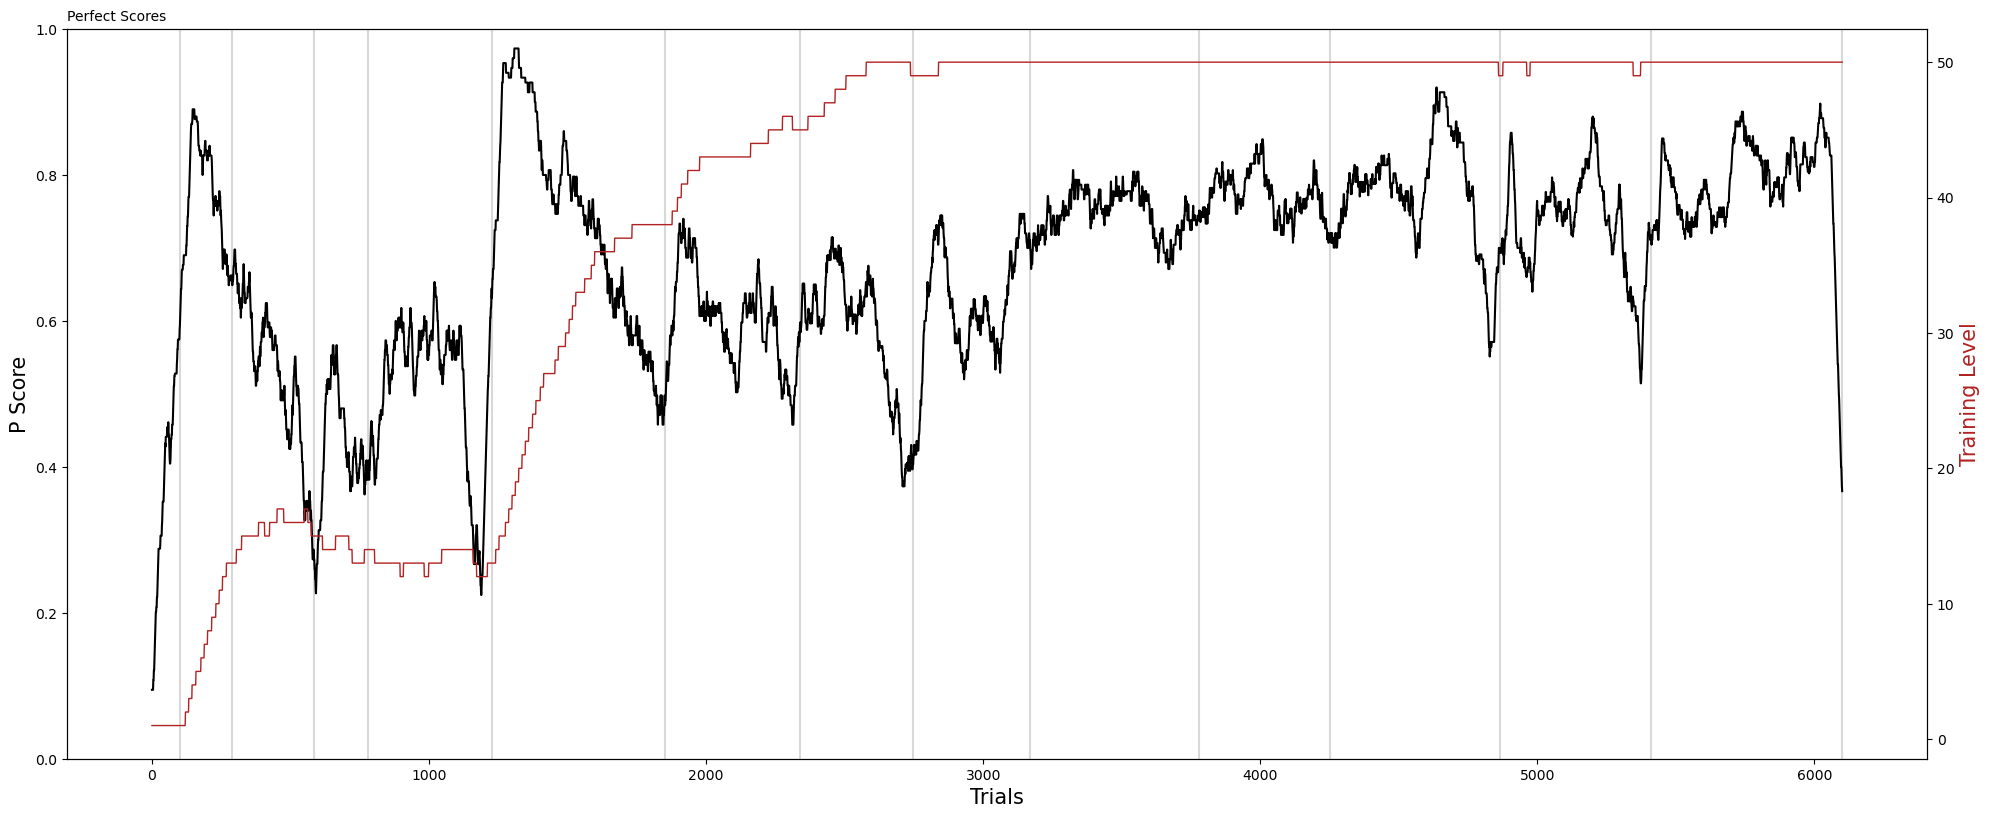

In [224]:
    trials_per_session= []
    for i in range(len(all_sessions_t_levels)):
        trials_per_session = trials_per_session + [len(all_sessions_t_levels[i])]
    cum_trials_per_session = np.cumsum(trials_per_session)

    TrainLevelsAll = sum(all_sessions_t_levels, [])

    LED_intensitiesAll = [[],[],[],[]]
    for ind in range(0,4):
        for i in range(len(all_sessions_LED_intensities)):
            LED_intensitiesAll[ind] = LED_intensitiesAll[ind] + all_sessions_LED_intensities[i][ind]
                                                                
    RewardValsAll = [[],[],[],[]]
    for ind in range(0,4):
        for i in range(len(all_sessions_Reward_amounts)):
            RewardValsAll[ind] = RewardValsAll[ind] + all_sessions_Reward_amounts[i][ind]

    perfectscore_trials = []
    for i in range(len(all_sessions_perfect_scores)):
        for trial in all_sessions_perfect_scores[i]:
            if len(trial) == 0:
                perfectscore_trials = perfectscore_trials + [0]
            else:
                perfectscore_trials = perfectscore_trials + [np.mean(trial)]

    # plot:
    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot2grid((5, 3), (1, 0), rowspan =5,colspan =3)   
    
    ax.set_ylim([0, 1])

    ax.plot(convolve_movmean(perfectscore_trials,75),color = 'black',linewidth = 1.5,zorder=11)


    ax.set_title('Perfect Scores', loc = 'left', size = 10, color = 'black')
    ax.set_xlabel('Trials', fontsize = 15)
    ax.set_ylabel('P Score',fontsize = 15, color = 'black')

    ax_2=ax.twinx()
    ax_2.plot(TrainLevelsAll,linewidth = 1,color = 'firebrick')
    ax_2.set_ylabel('Training Level',fontsize = 15, color = 'firebrick')
    
    for n_trials in cum_trials_per_session:
        ax.vlines(n_trials, 0, 1, color = 'grey',alpha = 0.3,zorder=10) 


     ## plot color gradients for reward and light guidance:

    if HighQuality == True:
        ax2 =  plt.subplot2grid((5, 3), (0, 0), rowspan =1,colspan =3)
        c1 = 'orange'
        c2 = 'navy'
        c3 = 'white'
        
        for i in range(0,4):
            for ind, value in enumerate(LED_intensitiesAll[i]):
                if ind == 0:
                    prev = 0
                else:
                    prev = ind-1

                normalised_value = value/90
                if not normalised_value == 0:
                    ax2.hlines(i+4, prev, ind, color=colorFader(c3,c1,normalised_value), linewidth=4)

                # plot an invisible point at the end to keep axis scaling the same
                if ind == len(LED_intensitiesAll[i]) - 1:
                    ax2.plot(ind,0,'.',color = 'white')

                normalised_Rvalue = RewardValsAll[i][ind]/5 # 5 = max r val
                if not normalised_Rvalue == 0:
                    ax2.hlines(i, prev, ind, color=colorFader(c3,c2,normalised_Rvalue), linewidth=4)

        ax2.set_frame_on(False)  

        labels=['Port 1 water','Port 2 water','Port 3 water','Port 4 water','Port 2 LED','Port 3 LED','Port 4 LED','Port 5 LED']
        ax2.set_yticks((0,1,2,3,4,5,6,7))
        ax2.set_yticklabels(labels)

        ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

    plt.tight_layout()   